#Image data preprocessing

For the image dataset we are working on a waste recycling plant dataset, which can be found on [Kaggle](https://www.kaggle.com/datasets/parohod/warp-waste-recycling-plant-dataset). There are three different versions of this dataset. We are using WaRP-C which contains cutout images of a single object. 
In this notebook we are going to process our dataset so that it can be used for machine learning classification. The first step is to import the libraries

In [14]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import v2
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader

In [15]:
def plot_20_images(dataset):
    df_sample = dataset.sample(n=20)
    print(df_sample)
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,10))
    count = 0
    for index, row in df_sample.iterrows():
        if count < 5:
            axes[0,count].imshow(row["image"])
        elif count < 10:
            axes[1, count-5].imshow(row["image"])
        elif count < 15:
            axes[2, count-10].imshow(row["image"])
        else:
            axes[3, count-15].imshow(row["image"])
        count += 1
    return fig, axes

## Loading the image dataset
Like before the first step is to load our image dataset into memory. We wil again use PIL Image to do this. However, this time we are only saving the image and their label into the pandas dataframe.

In [16]:
count = 0
images = pd.DataFrame(columns=["label", "image", "file_name"])
directory = 'datasets/Warp-C/'
for root_dir, cur_dir, files in os.walk(directory):
    print("root dir: " + str(root_dir))
    label = os.path.basename(os.path.normpath(root_dir))
    for file in files:
        if ".jpg" in file:
            file_name = root_dir +"/"+ file
            count += 1
            image = Image.open(file_name)
            row = [ label, image, file_name]
            images.loc[len(images)] = row

print("file count: " + str(count))
print(images)

root dir: datasets/Warp-C/
root dir: datasets/Warp-C/bottle-blue
root dir: datasets/Warp-C/bottle-blue-full
root dir: datasets/Warp-C/bottle-blue5l
root dir: datasets/Warp-C/bottle-blue5l-full
root dir: datasets/Warp-C/bottle-dark
root dir: datasets/Warp-C/bottle-dark-full
root dir: datasets/Warp-C/bottle-green
root dir: datasets/Warp-C/bottle-green-full
root dir: datasets/Warp-C/bottle-milk
root dir: datasets/Warp-C/bottle-milk-full
root dir: datasets/Warp-C/bottle-multicolor
root dir: datasets/Warp-C/bottle-multicolorv-full
root dir: datasets/Warp-C/bottle-oil
root dir: datasets/Warp-C/bottle-oil-full
root dir: datasets/Warp-C/bottle-transp
root dir: datasets/Warp-C/bottle-transp-full
root dir: datasets/Warp-C/bottle-yogurt
root dir: datasets/Warp-C/canister
root dir: datasets/Warp-C/cans
root dir: datasets/Warp-C/detergent-box
root dir: datasets/Warp-C/detergent-color
root dir: datasets/Warp-C/detergent-transparent
root dir: datasets/Warp-C/detergent-white
root dir: datasets/Warp-C/

In [17]:
def save_dataset(dataframe):
    for idx, row in dataframe.iterrows():
        row["image"].save(row["file_name"])

## Data transformation

### resizing your images
The first step for images is to resize them. A machine learning model has a set input size, which means that all input images need to have the same size. 

To resize an image you can use the following PIL Image function
<code>resized_image = image.resize((size_width, size_height))</code>

You will also have to work with a lambda expression. This means that you define a function (here a "resize" function) which you than call in the "apply" function on your dataframe so that each row in your dataframe will apply this function.

<code>
dataframe["image"] = dataframe["image"].apply(lambda img:function(inputs))
</code>
</br>

Don't forget to save your image dataset with DVC.

In [18]:
def resize_image(image, size):
    return image.resize(size)

                   label                                              image  \
4198          bottle-oil  <PIL.Image.Image image mode=RGB size=128x128 a...   
8642     detergent-white  <PIL.Image.Image image mode=RGB size=128x128 a...   
142          bottle-blue  <PIL.Image.Image image mode=RGB size=128x128 a...   
2178         bottle-dark  <PIL.Image.Image image mode=RGB size=128x128 a...   
2830        bottle-green  <PIL.Image.Image image mode=RGB size=128x128 a...   
8843     detergent-white  <PIL.Image.Image image mode=RGB size=128x128 a...   
1984         bottle-dark  <PIL.Image.Image image mode=RGB size=128x128 a...   
3206   bottle-green-full  <PIL.Image.Image image mode=RGB size=128x128 a...   
7430                cans  <PIL.Image.Image image mode=RGB size=128x128 a...   
7061            canister  <PIL.Image.Image image mode=RGB size=128x128 a...   
2772        bottle-green  <PIL.Image.Image image mode=RGB size=128x128 a...   
6255  bottle-transp-full  <PIL.Image.Image image mod

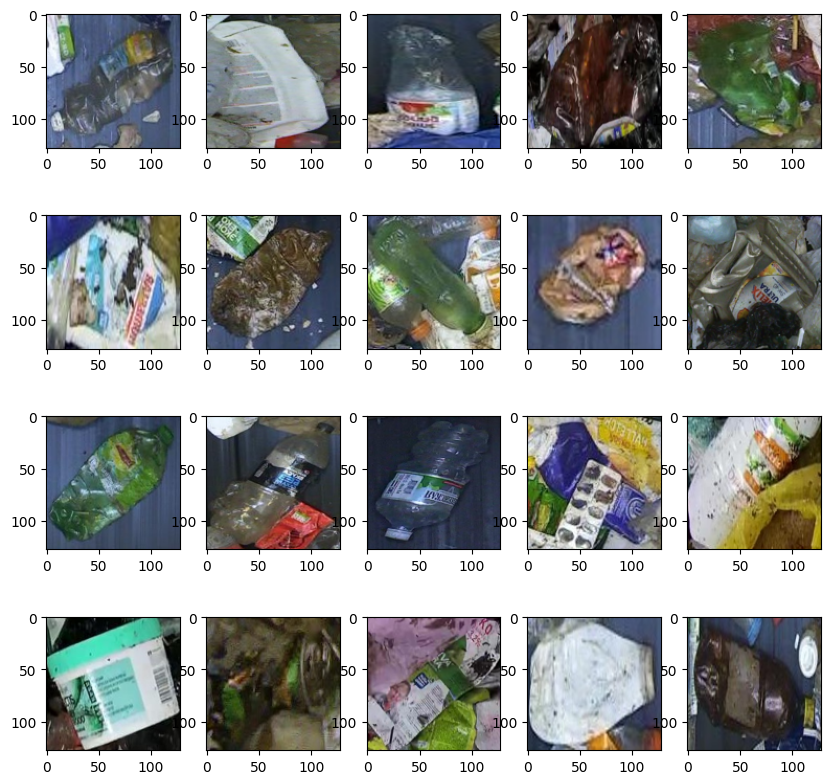

In [19]:
images_resize = images.copy()

images_resize["image"] = images_resize["image"].apply(lambda img:resize_image(img, (128,128)))

plot_20_images(images_resize)
save_dataset(images_resize)

### Data augmentation

when creating your image dataset, you might have taken a certain amount of pictures with a specific lighting setup or a specific camera angle. However, most of the time you want your model to be robust enough against different lighting setups, angles and noise. To help with this, you can use data augmentation and transform techniques. Here you add images to your dataset that are transformed versions of your original image. This can include things like cropping, changing colors, adding noice, rotating or flipping the image and many more. Pytorch has an easy way to add transformed images to your dataset. We use the same transformation technique as we did for normalization. You can find a list of the possible transformations [here](https://docs.pytorch.org/vision/stable/transforms.html). Try to implement at least 3 different transformations to the dataset. If you want to create a larger dataset, you can also add the transformed images to the original dataset.

In [20]:
def transform(image): 
    transforms = v2.Compose([

        v2.RandomResizedCrop(size=(128,128), antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.25,contrast=0.25,saturation=0.25, hue=[-0.25,0.25]),
    ])

    img = transforms(image)
    return img

                label                                              image  \
7256             cans  <PIL.Image.Image image mode=RGB size=128x128 a...   
321       bottle-blue  <PIL.Image.Image image mode=RGB size=128x128 a...   
5286    bottle-transp  <PIL.Image.Image image mode=RGB size=128x128 a...   
3391      bottle-milk  <PIL.Image.Image image mode=RGB size=128x128 a...   
3381      bottle-milk  <PIL.Image.Image image mode=RGB size=128x128 a...   
8068  detergent-color  <PIL.Image.Image image mode=RGB size=128x128 a...   
5328    bottle-transp  <PIL.Image.Image image mode=RGB size=128x128 a...   
9177      glass-green  <PIL.Image.Image image mode=RGB size=128x128 a...   
3565      bottle-milk  <PIL.Image.Image image mode=RGB size=128x128 a...   
2136      bottle-dark  <PIL.Image.Image image mode=RGB size=128x128 a...   
4775    bottle-transp  <PIL.Image.Image image mode=RGB size=128x128 a...   
174       bottle-blue  <PIL.Image.Image image mode=RGB size=128x128 a...   
8098  deterg

(<Figure size 1000x1000 with 20 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

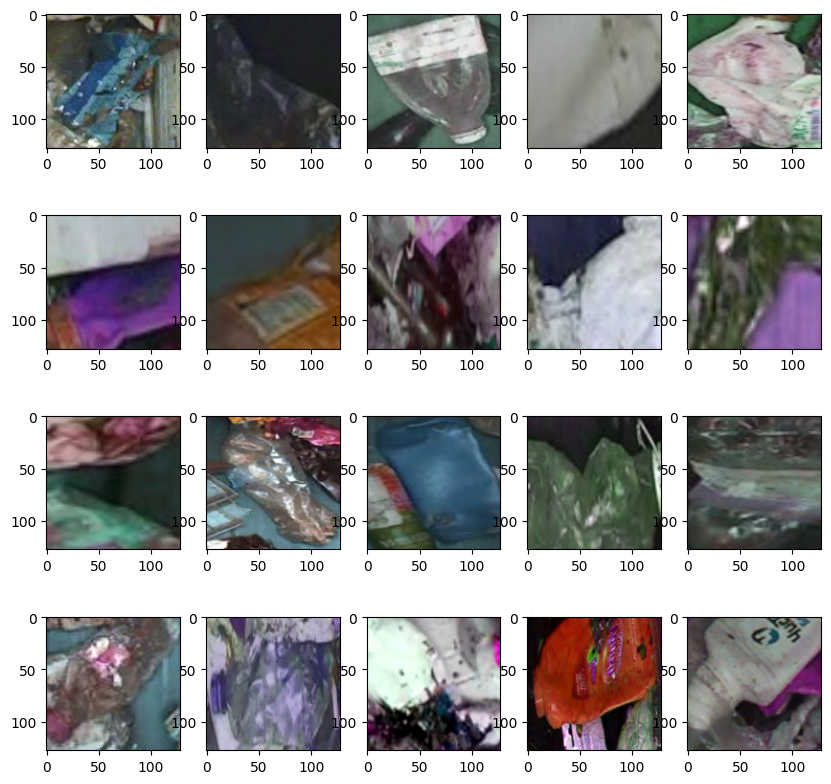

In [21]:
images_transf = images_resize.copy()
images_transf["image"] = images_transf["image"].apply(lambda img:transform(img))


plot_20_images(images_transf)

###  Normalizing your pixel values

Normaly your data is saved as three matrixes containing values between 0 and 255 (RGB values). However, sometimes, to create a consistent scale in your dataset it is again a good idea to normalize these values between 0 and 1. We will use a transform function from torchvision which transforms the data it is given in a certain way. The Normalize transform function uses the mean and standard deviation to calculate the normalized values. Therefore we first need to transform our PIL image to a Tensor image consisting of floats (this is only necessary for certain transformations, including normalization). Then we can calculate the mean and standard deviation. Lastly we transform our tensor image with the Normalize function. To implement this to all images, you can again use a lambda function. You will need the following code:

<code>transform = v2.Compose([<i>list, of, transformations</i>])</code></br>

    result = transform(image)
    
    mean = image_tensor.mean([1,2])
    std = image_tensor.std([1,2])

    change int to float: v2.ToDtype(torch.float32, scale=True)
    normalize: v2.Normalize(mean, std)
    convert PIL to tensor: v2.ToImage()
    Convert tensor to PIL: v2.ToPILImage()



In [22]:
def normalize_image(image):
    to_tensor_transform = v2.Compose([v2.ToImage(),
                                      v2.ToDtype(torch.float32, scale=True)])
    image_tensor = to_tensor_transform(image)
    mean, std = image_tensor.mean([1,2]), image_tensor.std([1,2])

    transform_norm = v2.Compose([
        v2.Normalize(mean, std),
        v2.ToPILImage()
    ])

    norm = transform_norm(image_tensor)
    return norm

                   label                                              image  \
7417                cans  <PIL.Image.Image image mode=RGB size=128x128 a...   
4150          bottle-oil  <PIL.Image.Image image mode=RGB size=128x128 a...   
7758                cans  <PIL.Image.Image image mode=RGB size=128x128 a...   
7519                cans  <PIL.Image.Image image mode=RGB size=128x128 a...   
8880     detergent-white  <PIL.Image.Image image mode=RGB size=128x128 a...   
221          bottle-blue  <PIL.Image.Image image mode=RGB size=128x128 a...   
2185         bottle-dark  <PIL.Image.Image image mode=RGB size=128x128 a...   
2045         bottle-dark  <PIL.Image.Image image mode=RGB size=128x128 a...   
6158  bottle-transp-full  <PIL.Image.Image image mode=RGB size=128x128 a...   
4407          bottle-oil  <PIL.Image.Image image mode=RGB size=128x128 a...   
5284       bottle-transp  <PIL.Image.Image image mode=RGB size=128x128 a...   
5305       bottle-transp  <PIL.Image.Image image mod

(<Figure size 1000x1000 with 20 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

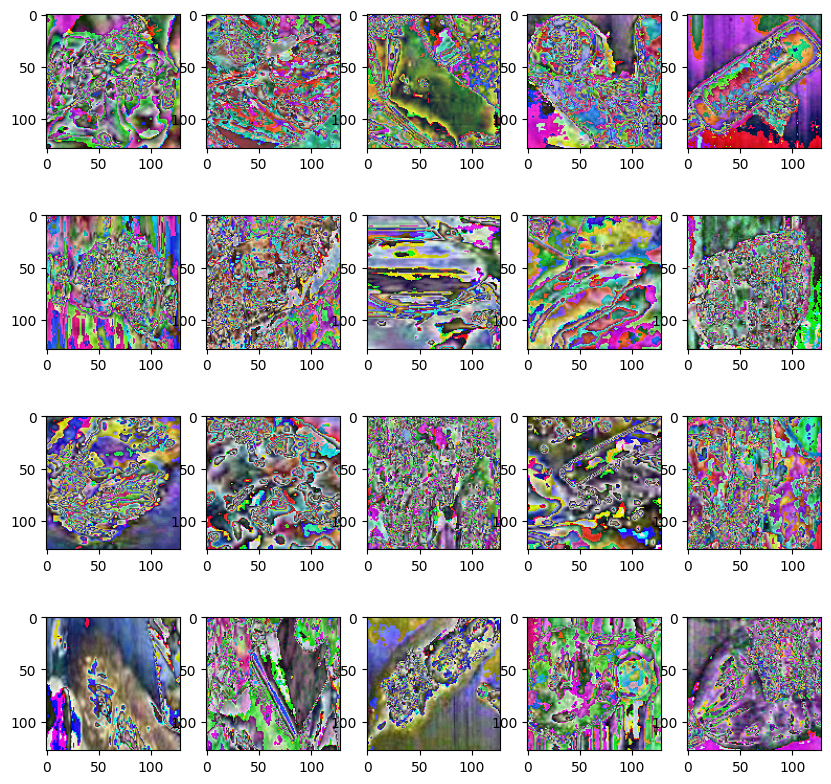

In [23]:
images_normal = images_transf.copy()
images_normal["image"] = images_normal["image"].apply(lambda img:normalize_image(img))
plot_20_images(images_normal)

### Dealing with class imbalance

In the original dataset we checked the amount of values per class. This is done to find the class imbalance. If there is one class which has a lot of data samples and another which has very little data samples, there might be some problems whilst training. You might find that the model learns to return the overrepresented class instead of actually learning something of value. This problem can be solved when creating the dataloader. There are several ways to deal with class imbalance. This in cludes oversampling (adding some samples multiple times from the unerrepresented class), undersampling (not adding some samples from the overrepresented class) or class weighting (sample the data with weigths respresenting the class imbalance). These techniques are sometimes done before training. However you can also add weigths to certain loss functions in pytorch which deal with class imbalances. In this exercise we are going to use a weighted random sampler in a dataloader. This means that we will create a torch dataset and dataloader and add the sampler to the dataloader as well. That way the data that the model will get whilst training will be sampled using the weigths of the class imbalances. 

First you will need to calculate the class weights. The class weigths are calculated as follows: 1/class_count .This means that we first need to count the number of times a certain class is represented. Do this for the image dataset.

    count = dataset["column"].value_counts().to_list()

In [24]:
class_counts = images_normal["label"].value_counts().to_list()
weigths = [1.0/count for count in class_counts]

When you have your clas weigths, they can be used in our WeightedRandomSampler. The weigths need to be transformed to tensors.

    samples_weigths = torch.from_numpy(np.array(weigths))
    sampler = WeightedRandomSampler(samples_weigths, len(samples_weights))

In [25]:
samples_weigths = torch.from_numpy(np.array(weigths))
sampler = WeightedRandomSampler(samples_weigths, len(samples_weigths))

Lastly we create a TensorDataset and DataLoader from our pandas dataframe. to represent your labels as a one-hot-encoding we created a function for you. We also created a custom torch Dataset to be able to use in the Dataloader since we use PIL images instead of tensors.

In [26]:
def create_onehotlabels(images_normal):
    result = pd.get_dummies(images_normal["label"])
    onehotlist = []
    for idxm, row in result.iterrows():
        boollist= row[1:].tolist()
        onehotlist.append([int(value) for value in boollist])

    images_normal["label"] = onehotlist

    return images_normal

In [27]:

class ImageLabelDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transformer = v2.ToTensor()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.transformer(self.dataframe.iloc[idx]['image'])
        label = self.dataframe.iloc[idx]['label']
        label = torch.tensor(label, dtype=torch.float32)

        return image, label


Use all previously defined functions and classes to create a dataloader:

    dataset = ImageLabelDataset(images)
    dataloader = DataLoader(dataset, batch_size, sampler=sampler)

In [28]:
images_onehot = create_onehotlabels(images_normal)
dataset = ImageLabelDataset(images_onehot)
dataloader = DataLoader(dataset, 8, sampler=sampler)
print(dataloader)

c:\Users\laral\Visual_studio_code\workshop_all\MLOps4ECM_day1\environment\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [29]:
for image, label in dataloader:
    print(image)
    print(label)

tensor([[[[0.9137, 0.9137, 0.1216,  ..., 0.0706, 0.1216, 0.1216],
          [0.9137, 0.9137, 0.1216,  ..., 0.0706, 0.1216, 0.1216],
          [0.4431, 0.4431, 0.6588,  ..., 0.0706, 0.1216, 0.1216],
          ...,
          [0.4902, 0.4902, 0.3843,  ..., 0.6471, 0.6471, 0.6471],
          [0.4353, 0.4353, 0.2235,  ..., 0.6471, 0.6471, 0.6471],
          [0.4353, 0.4353, 0.2235,  ..., 0.6471, 0.6471, 0.6471]],

         [[0.6275, 0.6275, 0.7765,  ..., 0.4275, 0.4784, 0.4784],
          [0.6784, 0.6784, 0.7765,  ..., 0.4275, 0.4784, 0.4784],
          [0.1725, 0.1725, 0.2706,  ..., 0.4275, 0.4784, 0.4784],
          ...,
          [0.7216, 0.7216, 0.6196,  ..., 0.9804, 0.9804, 0.9804],
          [0.6706, 0.6706, 0.5216,  ..., 0.9804, 0.9804, 0.9804],
          [0.6706, 0.6706, 0.5216,  ..., 0.9804, 0.9804, 0.9804]],

         [[0.1529, 0.1529, 0.3373,  ..., 0.1529, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.3373,  ..., 0.1529, 0.2000, 0.2000],
          [0.7059, 0.7059, 0.7490,  ..., 0